# Sampling and Plotting

In [1]:
import sys
sys.path.append('C:\\UWMadisonResearch\\SGM_FNO_Closure\\DiffusionTerm_Generation')

import h5py
import torch
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from functools import partial
import warnings
warnings.filterwarnings("ignore")
from utility import (set_seed, energy_spectrum, get_sigmas_karras, sampler, plot_heatmaps_sample)
from Model_Designs import (marginal_prob_std, diffusion_coeff,FNO2d_Interp, FNO2d_Conv)

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device('cuda')
else:
    print("CUDA is not available.")
    device = torch.device('cpu')

CUDA is available.


## Load testing data and models

In [2]:
test_file = 'C:\\UWMadisonResearch\\SGM_FNO_Closure\\Data_Generation\\test_diffusion.h5'
with h5py.File(test_file, 'r') as file:
    test_diffusion_64 = torch.tensor(file['test_diffusion_64'][:], device=device)
    test_vorticity_64 = torch.tensor(file['test_vorticity_64'][:], device=device)
    test_diffusion_128 = torch.tensor(file['test_diffusion_128'][:], device=device)
    test_vorticity_128 = torch.tensor(file['test_vorticity_128'][:], device=device)
    test_diffusion_256 = torch.tensor(file['test_diffusion_256'][:], device=device)
    test_vorticity_256 = torch.tensor(file['test_vorticity_256'][:], device=device)
    test_diffusion_64_sparse_interp = torch.tensor(file['test_diffusion_64_sparse_interp'][:], device=device)
    test_diffusion_128_sparse_interp = torch.tensor(file['test_diffusion_128_sparse_interp'][:], device=device)
    test_diffusion_256_sparse_interp = torch.tensor(file['test_diffusion_256_sparse_interp'][:], device=device)
    test_diffusion_64_sparse_normalized = torch.tensor(file['test_diffusion_64_sparse_normalized'][:], device=device)
    test_diffusion_128_sparse_normalized = torch.tensor(file['test_diffusion_128_sparse_normalized'][:], device=device)
    test_diffusion_256_sparse_normalized = torch.tensor(file['test_diffusion_256_sparse_normalized'][:], device=device)

In [3]:
sigma = 26
marginal_prob_std_fn = partial(marginal_prob_std, sigma=sigma, device_=device)
diffusion_coeff_fn = partial(diffusion_coeff, sigma=sigma, device_=device)

modes = 8
width = 20

model_interp = FNO2d_Interp(marginal_prob_std_fn, modes, modes, width).cuda()
model_interp.load_state_dict(torch.load('C:\\UWMadisonResearch\\SGM_FNO_Closure\\DiffusionTerm_Generation'
                  '\\Trained_Models\\SparseDiffusionModelMidV_3040_interp.pth', map_location=device))

model_conv = FNO2d_Conv(marginal_prob_std_fn, modes, modes, width).cuda()
model_conv.load_state_dict(torch.load('C:\\UWMadisonResearch\\SGM_FNO_Closure\\DiffusionTerm_Generation'
                  '\\Trained_Models\\SparseDiffusionModelMidV_3040_conv.pth', map_location=device))

<All keys matched successfully>

## Sampling

In [4]:
sde_time_data: float = 0.5
sde_time_min = 1e-3
sde_time_max = 0.1
sample_steps = 10
sample_batch_size = 100

time_noises = get_sigmas_karras(sample_steps, sde_time_min, sde_time_max, device=device)

sampler = partial(sampler,
                    marginal_prob_std = marginal_prob_std_fn,
                    diffusion_coeff = diffusion_coeff_fn,
                    batch_size = sample_batch_size,
                    num_steps = sample_steps,
                    time_noises = time_noises,
                    device = device)

### Interpolation Model Sampling

In [6]:
samples_64_interp = sampler(test_vorticity_64[:sample_batch_size, :, :], test_diffusion_64_sparse_interp[:sample_batch_size, :, :], model_interp, spatial_dim=64)
samples_128_interp = sampler(test_vorticity_128[:sample_batch_size, :, :], test_diffusion_128_sparse_interp[:sample_batch_size, :, :], model_interp, spatial_dim=128)
samples_256_interp = sampler(test_vorticity_256[:sample_batch_size, :, :], test_diffusion_256_sparse_interp[:sample_batch_size, :, :], model_interp, spatial_dim=256)

#### Evaluations

In [7]:
### MSE and Relative Error
mse_64_interp = torch.mean((samples_64_interp - test_diffusion_64[:sample_batch_size, :, :])**2)
rel_64_interp = torch.mean( torch.norm(samples_64_interp - test_diffusion_64[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_diffusion_64[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_128_interp = torch.mean((samples_128_interp - test_diffusion_128[:sample_batch_size, :, :])**2)
rel_128_interp = torch.mean( torch.norm(samples_128_interp - test_diffusion_128[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_diffusion_128[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_256_interp = torch.mean((samples_256_interp - test_diffusion_256[:sample_batch_size, :, :])**2)
rel_256_interp = torch.mean( torch.norm(samples_256_interp - test_diffusion_256[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_diffusion_256[:sample_batch_size, :, :], 2, dim=(1, 2)))

print(f"MSE 64 Interp: {mse_64_interp:.8f}, Relative Error 64 Interp: {rel_64_interp:.4f}")
print(f"MSE 128 Interp: {mse_128_interp:.8f}, Relative Error 128 Interp: {rel_128_interp:.4f}")
print(f"MSE 256 Interp: {mse_256_interp:.8f}, Relative Error 256 Interp: {rel_256_interp:.4f}")

MSE 64 Interp: 0.00015501, Relative Error 64 Interp: 0.0923
MSE 128 Interp: 0.00026285, Relative Error 128 Interp: 0.1298
MSE 256 Interp: 0.00041748, Relative Error 256 Interp: 0.1659


Random seed set as 12


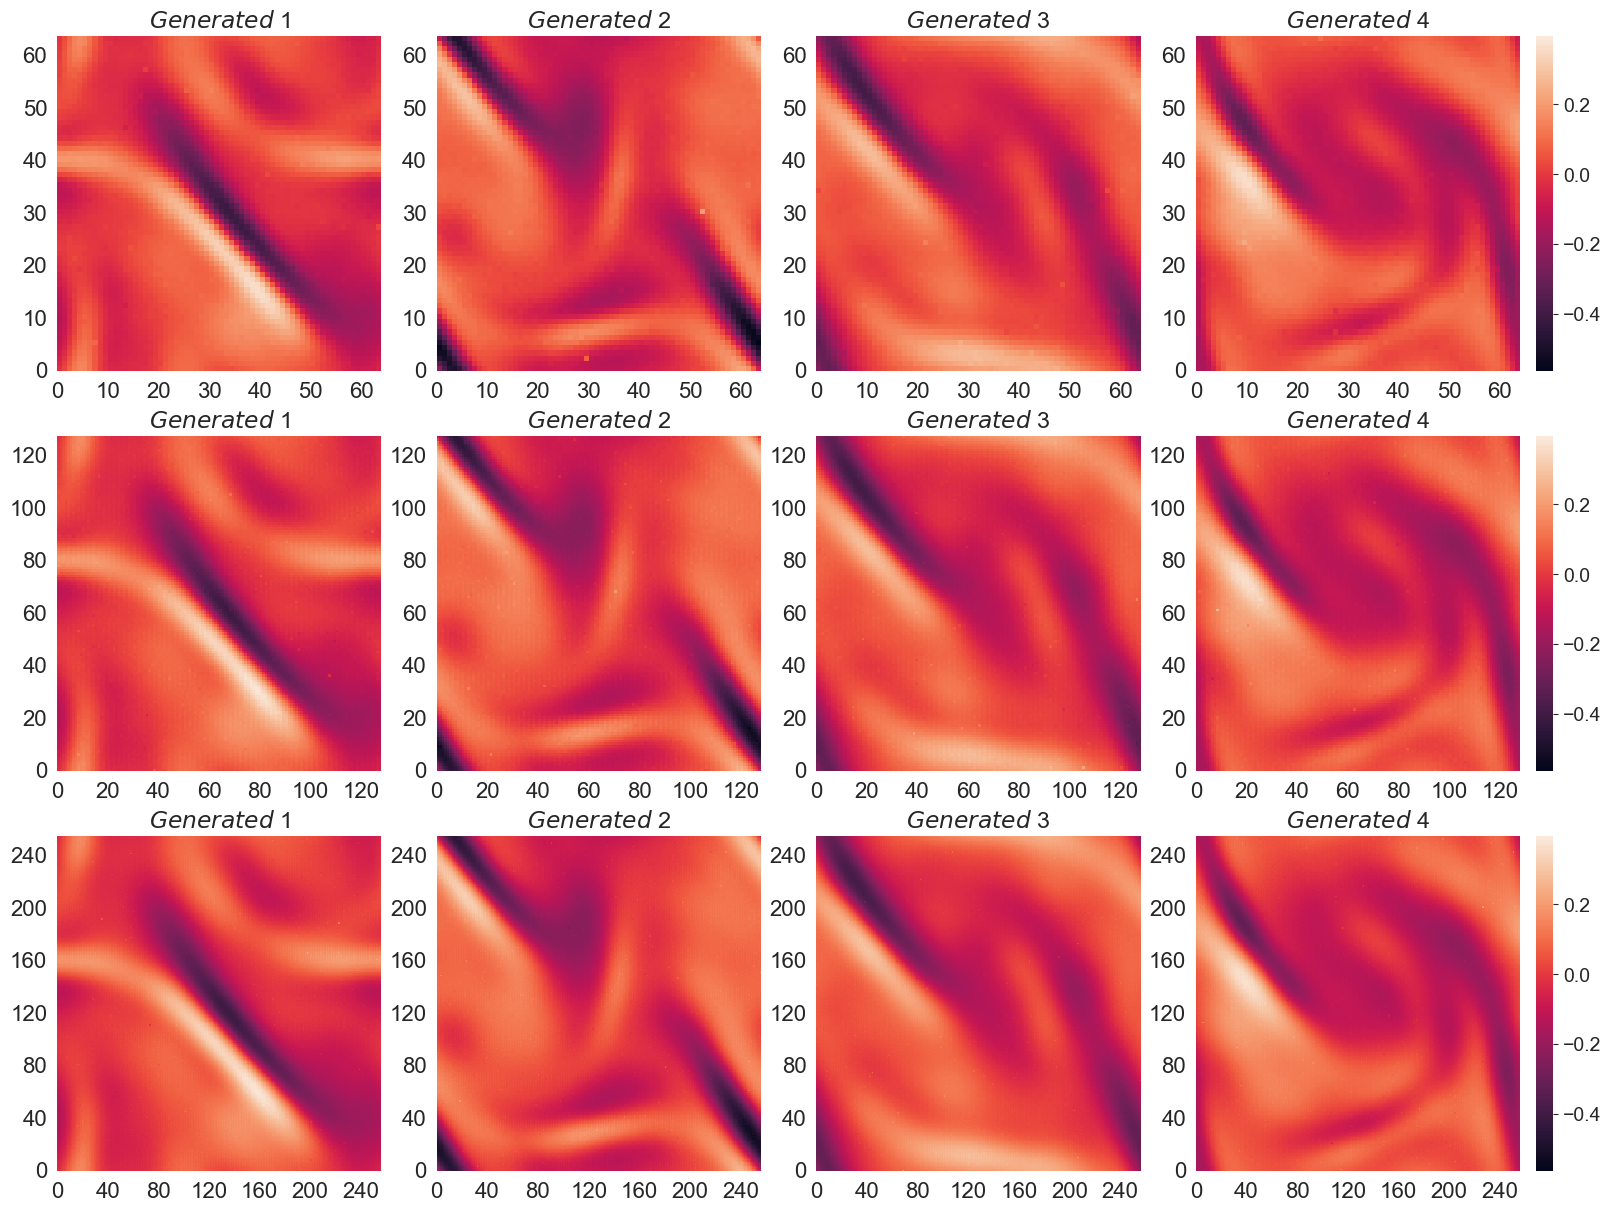

In [8]:
plot_heatmaps_sample(samples_64_interp, samples_128_interp, samples_256_interp)

### Convolution Model Sampling

In [9]:
samples_64_conv = sampler(test_vorticity_64[:sample_batch_size, :, :], test_diffusion_64_sparse_normalized[:sample_batch_size, :, :], model_conv, spatial_dim=64)
samples_128_conv = sampler(test_vorticity_128[:sample_batch_size, :, :], test_diffusion_128_sparse_normalized[:sample_batch_size, :, :], model_conv, spatial_dim=128)
samples_256_conv = sampler(test_vorticity_256[:sample_batch_size, :, :], test_diffusion_256_sparse_normalized[:sample_batch_size, :, :], model_conv, spatial_dim=256)

#### Evaluations

In [10]:
### MSE and Relative Error
mse_64_conv = torch.mean((samples_64_conv - test_diffusion_64[:sample_batch_size, :, :])**2)
rel_64_conv = torch.mean( torch.norm(samples_64_conv - test_diffusion_64[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_diffusion_64[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_128_conv = torch.mean((samples_128_conv - test_diffusion_128[:sample_batch_size, :, :])**2)
rel_128_conv = torch.mean( torch.norm(samples_128_conv - test_diffusion_128[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_diffusion_128[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_256_conv = torch.mean((samples_256_conv - test_diffusion_256[:sample_batch_size, :, :])**2)
rel_256_conv = torch.mean( torch.norm(samples_256_conv - test_diffusion_256[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_diffusion_256[:sample_batch_size, :, :], 2, dim=(1, 2)))

print(f"MSE 64 Conv: {mse_64_conv:.8f}, Relative Error 64 Conv: {rel_64_conv:.4f}")
print(f"MSE 128 Conv: {mse_128_conv:.8f}, Relative Error 128 Conv: {rel_128_conv:.4f}")
print(f"MSE 256 Conv: {mse_256_conv:.8f}, Relative Error 256 Conv: {rel_256_conv:.4f}")

MSE 64 Conv: 0.00013553, Relative Error 64 Conv: 0.0929
MSE 128 Conv: 0.00019200, Relative Error 128 Conv: 0.1113
MSE 256 Conv: 0.00028235, Relative Error 256 Conv: 0.1353


Random seed set as 12


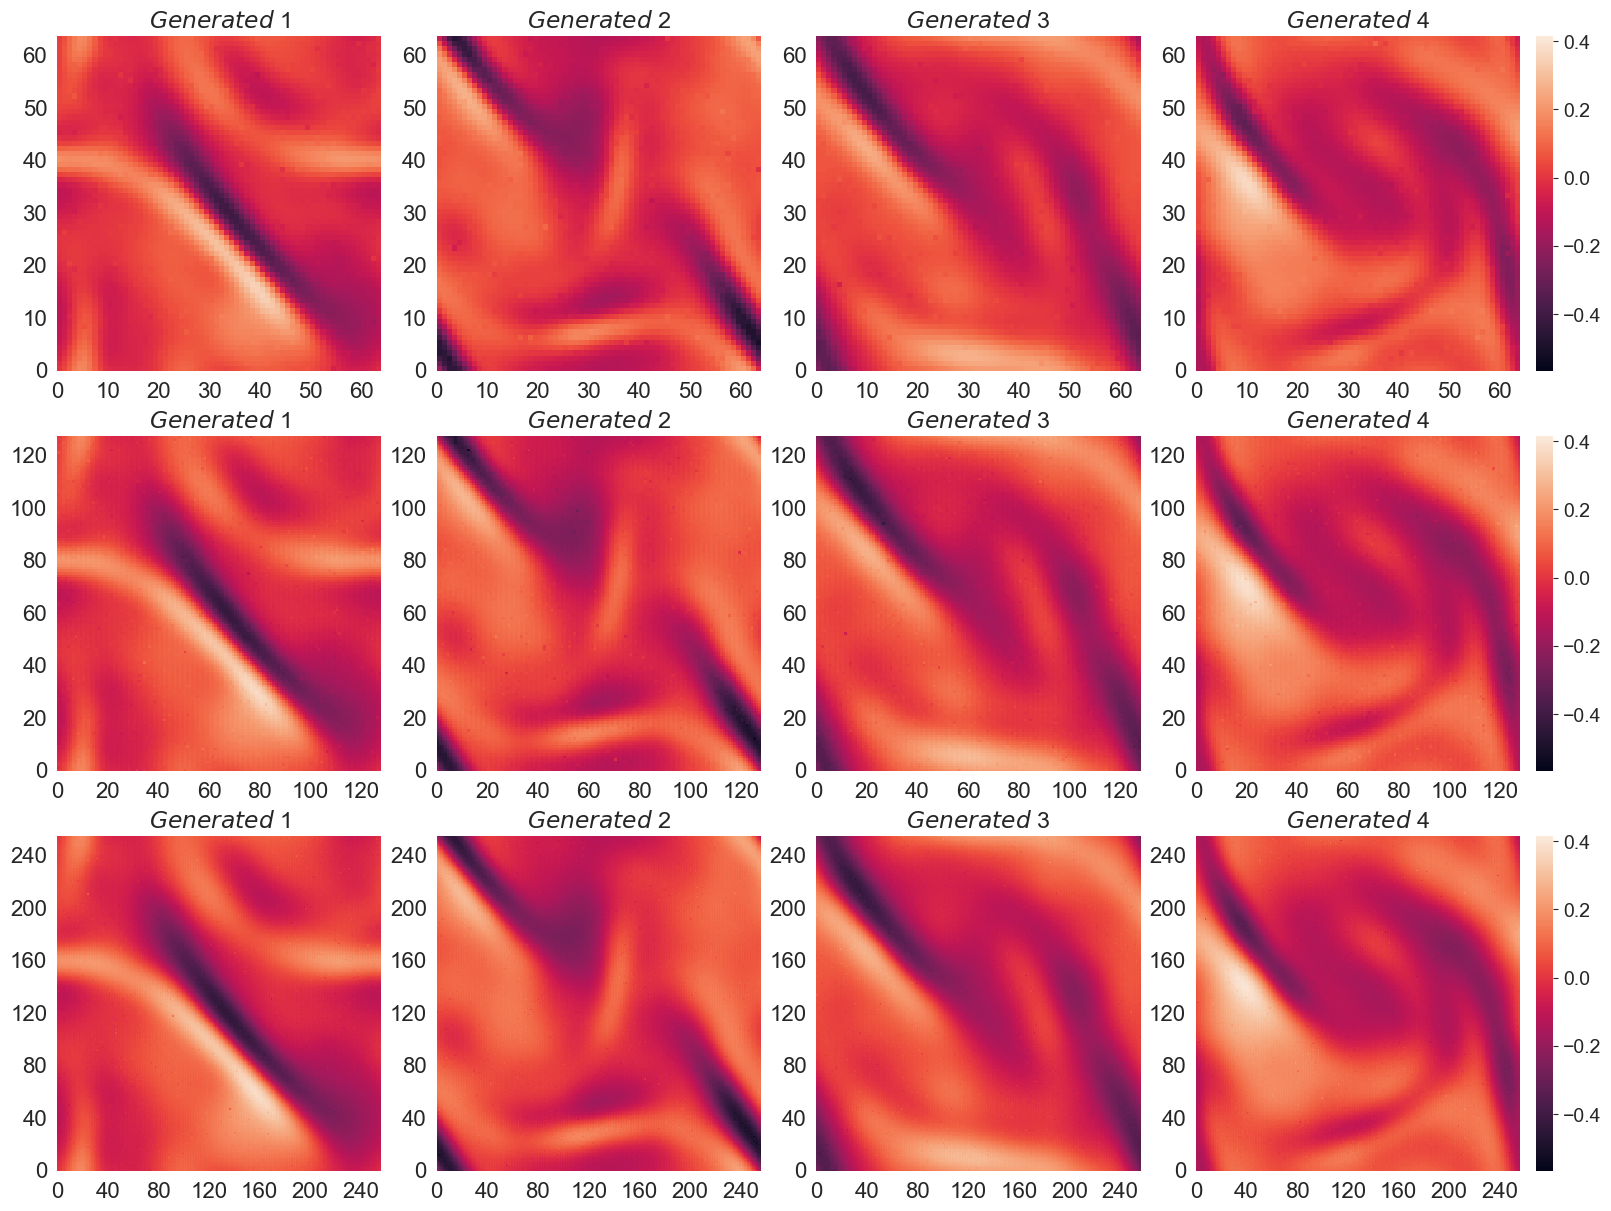

In [11]:
plot_heatmaps_sample(samples_64_conv, samples_128_conv, samples_256_conv)

### Energy Spectral

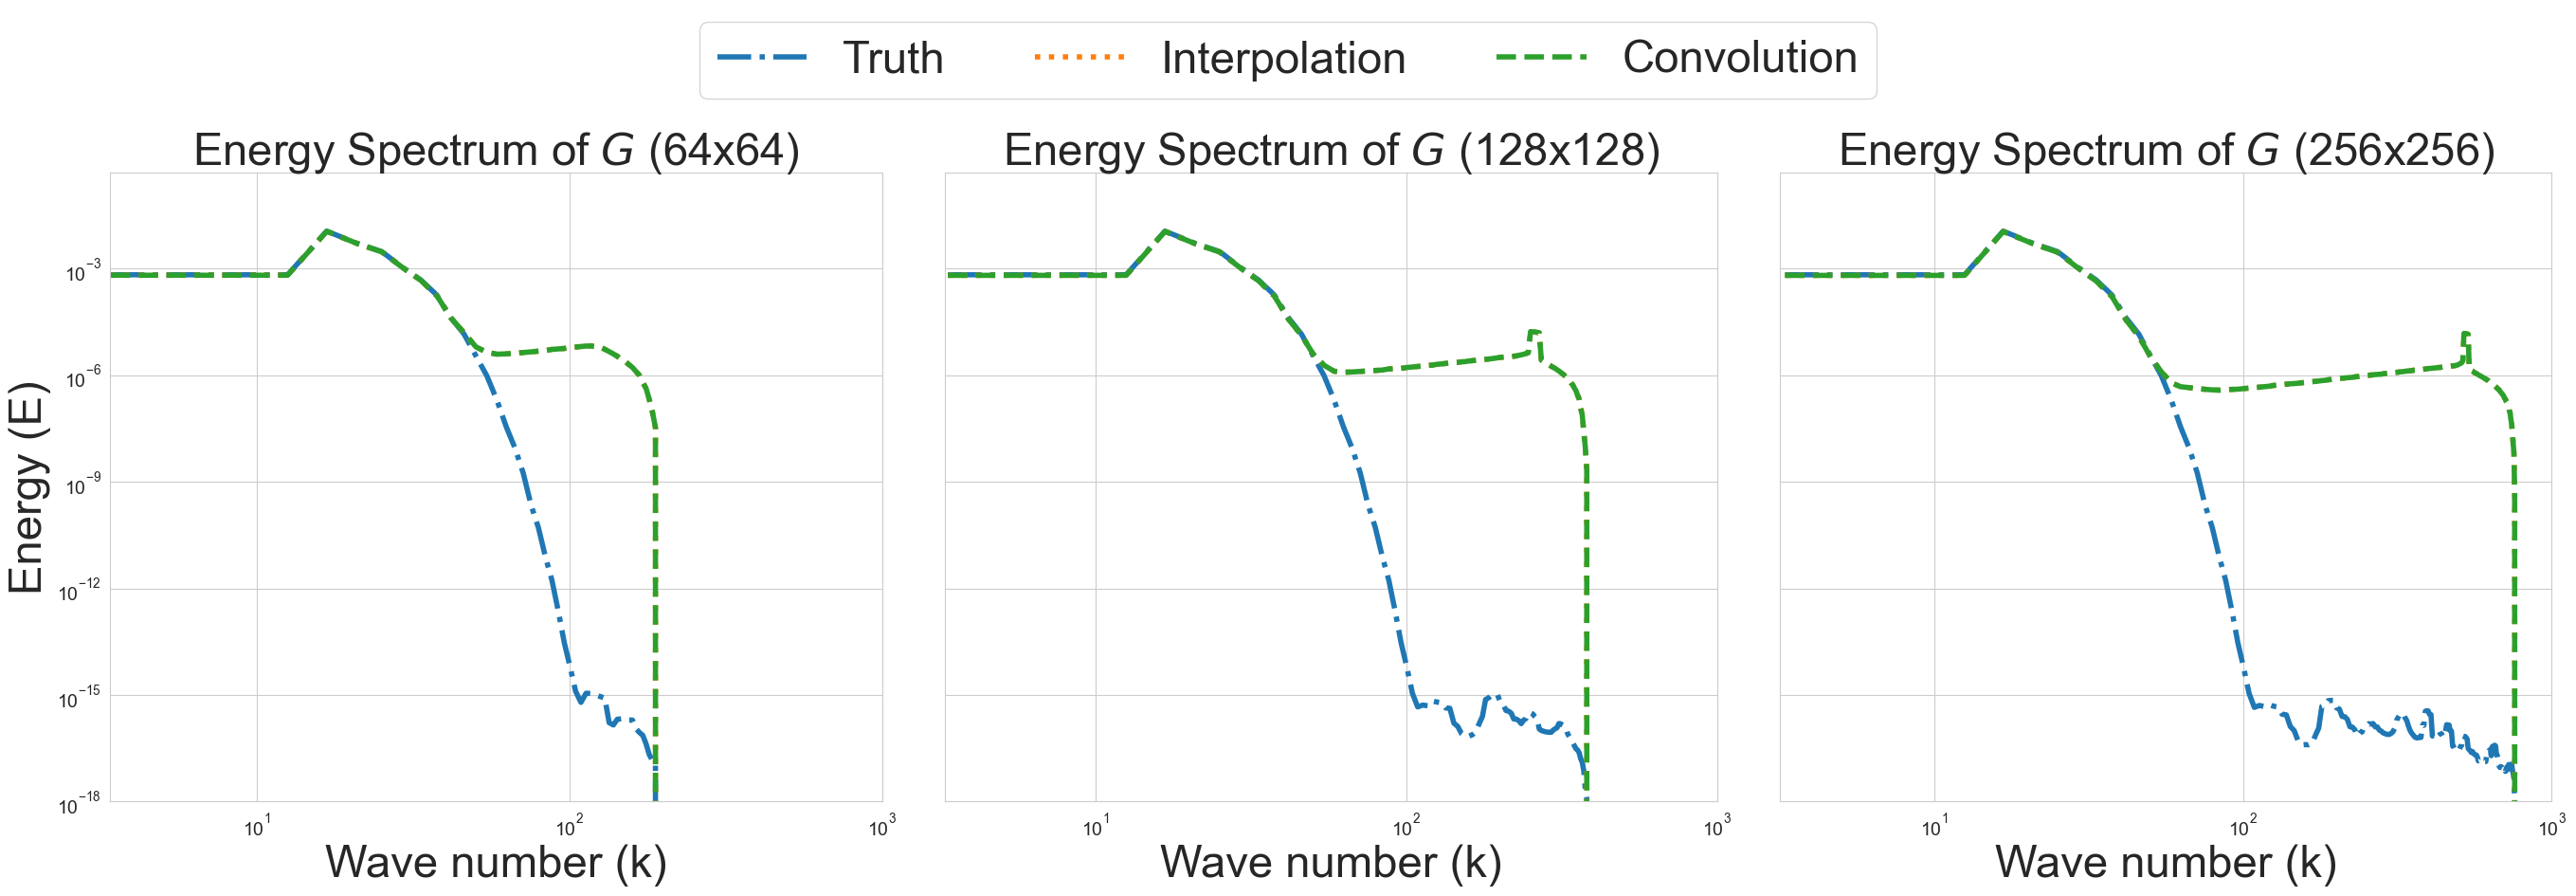

In [12]:

k64_gauss, E64_gauss = energy_spectrum(samples_64_interp.cpu())[1:]
k128_gauss, E128_gauss = energy_spectrum(samples_128_interp.cpu())[1:]
k256_gauss, E256_gauss = energy_spectrum(samples_256_interp.cpu())[1:]


k64_interp, E64_interp = energy_spectrum(samples_64_interp.cpu())[1:]
k128_interp, E128_interp = energy_spectrum(samples_128_interp.cpu())[1:]
k256_interp, E256_interp = energy_spectrum(samples_256_interp.cpu())[1:]

k_truth_64, E_truth_64 = energy_spectrum(test_diffusion_64[:sample_batch_size, :, :].cpu())[1:]
k_truth_128, E_truth_128 = energy_spectrum(test_diffusion_128[:sample_batch_size, :, :].cpu())[1:]
k_truth_256, E_truth_256 = energy_spectrum(test_diffusion_256[:sample_batch_size, :, :].cpu())[1:]

resolutions = [64, 128, 256]
gauss_kn = [k64_gauss, k128_gauss, k256_gauss]
gauss_E = [E64_gauss, E128_gauss, E256_gauss]

interp_kn = [k64_interp, k128_interp, k256_interp]
interp_E = [E64_interp, E128_interp, E256_interp]

truth_kn = [k_truth_64, k_truth_128, k_truth_256]
truth_E = [E_truth_64, E_truth_128, E_truth_256]

fig, axs = plt.subplots(1, 3, figsize=(28, 10), sharey=True)
fs = 34
plt.rcParams.update({'font.size': fs})
plt.rcParams.update({'legend.fontsize': 35})  # Ensure the legend font size is updated


for i, res in enumerate(resolutions):
    # Upper row plots
    col = i
    axs[col].loglog(truth_kn[i], truth_E[i], label='Truth', linestyle='-.', linewidth=4)
    axs[col].loglog(interp_kn[i], interp_E[i], label='Interpolation', linestyle=':', linewidth=4)
    axs[col].loglog(gauss_kn[i], gauss_E[i], label='Convolution', linestyle='--', linewidth=4)

    axs[col].set_ylim(1e-18, 5 * 1e-1)
    axs[col].set_xlim(0, 1e3)
    axs[col].set_xscale('log')
    axs[col].set_yscale('log')
    axs[col].set_title(f'Energy Spectrum of $G$ ({res}x{res})', fontsize = fs)
    axs[col].set_xlabel('Wave number (k)', fontsize = fs)

axs[0].set_ylabel('Energy (E)', fontsize=fs)

for ax in axs.flat:
    ax.set_ylim(1e-18, 5 * 1e-1)
    ax.set_xlim(0, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')

# Create a shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=fs)
# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust this value as needed
plt.show()